# spark-bestfit API Demo

This notebook demonstrates the complete API for the `spark-bestfit` library, including:

1. **Distribution Fitting** - Using DistributionFitter with direct parameters
2. **Progress Tracking** - Monitor long-running fits with callbacks
3. **Working with Results** - FitResults and DistributionFitResult objects
4. **Lazy Metrics** - Skip KS/AD computation for faster model selection (v1.5.0+)
5. **Confidence Intervals** - Bootstrap confidence intervals for fitted parameters
6. **Plotting** - Visualization with customizable parameters
7. **Excluding Distributions** - Customizing which distributions to fit
8. **Serialization** - Save and load fitted distributions

## Setup

First, let's create a Spark session. Note: **You** are responsible for creating and configuring your SparkSession.

In [1]:
import numpy as np
from pyspark.sql import SparkSession

# Create Spark session (your responsibility - configure as needed for your environment)
spark = (
    SparkSession.builder
    .appName("API-Demo")
    .config("spark.sql.shuffle.partitions", "10")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/01 21:36:20 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/01 21:36:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


26/01/01 21:36:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


In [2]:
# Import spark-bestfit components
from spark_bestfit import (
    DistributionFitter,
    DEFAULT_EXCLUDED_DISTRIBUTIONS,
)

## Generate Sample Data

We'll create sample data from known distributions for demonstration.

In [3]:
np.random.seed(42)

# Normal distribution data
normal_data = np.random.normal(loc=50, scale=10, size=50_000)
df_normal = spark.createDataFrame([(float(x),) for x in normal_data], ["value"])

# Exponential distribution data (non-negative)
exp_data = np.random.exponential(scale=5, size=50_000)
df_exp = spark.createDataFrame([(float(x),) for x in exp_data], ["value"])

# Gamma distribution data
gamma_data = np.random.gamma(shape=2.0, scale=2.0, size=50_000)
df_gamma = spark.createDataFrame([(float(x),) for x in gamma_data], ["value"])

print(f"Normal data: {df_normal.count():,} rows, mean={normal_data.mean():.2f}, std={normal_data.std():.2f}")
print(f"Exponential data: {df_exp.count():,} rows, mean={exp_data.mean():.2f}")
print(f"Gamma data: {df_gamma.count():,} rows, mean={gamma_data.mean():.2f}")

Normal data: 50,000 rows, mean=50.00, std=10.00
Exponential data: 50,000 rows, mean=4.97
Gamma data: 50,000 rows, mean=4.01


---

# Part 1: Excluded Distributions

spark-bestfit excludes some slow distributions by default. You can customize this.

## 1.1 DEFAULT_EXCLUDED_DISTRIBUTIONS

Some distributions are excluded by default because they are very slow to fit.

In [4]:
# View default excluded distributions
print(f"Default excluded distributions ({len(DEFAULT_EXCLUDED_DISTRIBUTIONS)}):")
for dist in sorted(DEFAULT_EXCLUDED_DISTRIBUTIONS):
    print(f"  - {dist}")

Default excluded distributions (17):
  - exonpow
  - gausshyper
  - genhyperbolic
  - geninvgauss
  - kappa4
  - ksone
  - kstwo
  - kstwobign
  - levy_stable
  - mielke
  - ncf
  - ncx2
  - recipinvgauss
  - studentized_range
  - vonmises
  - vonmises_line
  - wald


In [5]:
# Include a specific distribution that's excluded by default
custom_exclusions = tuple(d for d in DEFAULT_EXCLUDED_DISTRIBUTIONS if d != "wald")

fitter_with_wald = DistributionFitter(spark, excluded_distributions=custom_exclusions)
print(f"Now fitting 'wald' distribution (removed from exclusions)")

Now fitting 'wald' distribution (removed from exclusions)


---

# Part 2: Distribution Fitting

The `DistributionFitter` class is the main entry point for fitting distributions.

## 2.1 Basic Fitting

In [6]:
# Create fitter with default config
fitter = DistributionFitter(spark)

# Fit distributions to normal data (limit to 20 for demo speed)
print("Fitting distributions to normal data...")
results_normal = fitter.fit(df_normal, column="value", max_distributions=20)

print(f"\nFitted {results_normal.count()} distributions")

Fitting distributions to normal data...



Fitted 20 distributions


## 2.2 Fitting with Custom Parameters

In [7]:
# Fit only non-negative distributions using support_at_zero=True
fitter_nonneg = DistributionFitter(spark)

print("Fitting non-negative distributions to exponential data...")
results_exp = fitter_nonneg.fit(
    df_exp,
    column="value",
    bins=100,
    support_at_zero=True,  # Only fit non-negative distributions
    enable_sampling=True,
    max_distributions=15,
)

print(f"Fitted {results_exp.count()} non-negative distributions")

Fitting non-negative distributions to exponential data...


Fitted 15 non-negative distributions


## 2.3 Progress Tracking

For long-running fits, you can monitor progress with a callback. The easiest way is to use the built-in `console_progress()` utility:

```python
from spark_bestfit.progress import console_progress

results = fitter.fit(df, column="value", progress_callback=console_progress())
```

For custom callbacks, pass any function matching `(completed: int, total: int, percent: float) -> None`.

**Note**: Progress percentages may fluctuate as new Spark stages add tasks. This is normal - progress generally trends upward.

In [8]:
from spark_bestfit.progress import console_progress

# Simple approach: use built-in console_progress()
print("Fitting with console_progress()...")
fitter_progress = DistributionFitter(spark)
results_progress = fitter_progress.fit(
    df_normal,
    column="value",
    max_distributions=25,
    progress_callback=console_progress("Fitting"),  # Built-in utility
)
print()  # Newline after progress
print(f"Fitted {results_progress.count()} distributions")

Fitting with console_progress()...
Fitting: 21/42 tasks (50.0%)

Fitting: 34/85 tasks (40.0%)

Fitting: 35/85 tasks (41.2%)

Fitting: 40/85 tasks (47.1%)

Fitting: 41/85 tasks (48.2%)

Fitting: 44/85 tasks (51.8%)

Fitting: 67/156 tasks (42.9%)

Fitting: 73/156 tasks (46.8%)

Fitting: 75/186 tasks (40.3%)

Fitting: 82/186 tasks (44.1%)

Fitting: 91/186 tasks (48.9%)

Fitting: 94/186 tasks (50.5%)

Fitting: 95/216 tasks (44.0%)


Fitted 25 distributions


## 2.4 Using Active SparkSession

If a SparkSession is already active, you don't need to pass it explicitly.

In [9]:
# DistributionFitter can use the active session automatically
fitter_active = DistributionFitter()  # No spark parameter needed
print(f"Using active session: {fitter_active.spark.sparkContext.appName}")

Using active session: API-Demo


---

# Part 3: Working with Results

The `fit()` method returns a `FitResults` object for easy result manipulation.

## 3.1 Getting Best Distributions

In [10]:
# Get best distribution (by K-S statistic, the default)
best = results_normal.best(n=1)[0]
print(f"Best by K-S statistic: {best.distribution}")
print(f"  K-S statistic: {best.ks_statistic:.6f}")
print(f"  p-value: {best.pvalue:.4f}")
print(f"  A-D statistic: {best.ad_statistic:.6f}")
print(f"  A-D p-value: {best.ad_pvalue:.4f}" if best.ad_pvalue else f"  A-D p-value: N/A (not available for {best.distribution})")
print(f"  SSE: {best.sse:.6f}")
print(f"  AIC: {best.aic:.2f}")
print(f"  BIC: {best.bic:.2f}")
print(f"  Parameters: {[f'{p:.4f}' for p in best.parameters]}")

Best by K-S statistic: beta
  K-S statistic: 0.005230
  p-value: 0.9458
  A-D statistic: 0.162459
  A-D p-value: N/A (not available for beta)
  SSE: 0.000013
  AIC: 74641.52
  BIC: 74670.37
  Parameters: ['162.1686', '127.8387', '-143.6824', '346.2217']


In [11]:
# Get top 5 by different metrics
print("Top 5 by K-S statistic (default):")
for i, r in enumerate(results_normal.best(n=5), 1):
    print(f"  {i}. {r.distribution:20s} KS={r.ks_statistic:.6f} p={r.pvalue:.4f}")

print("\nTop 5 by A-D statistic:")
for i, r in enumerate(results_normal.best(n=5, metric="ad_statistic"), 1):
    ad_p = f"{r.ad_pvalue:.4f}" if r.ad_pvalue else "N/A"
    print(f"  {i}. {r.distribution:20s} AD={r.ad_statistic:.6f} p={ad_p}")

print("\nTop 5 by SSE:")
for i, r in enumerate(results_normal.best(n=5, metric="sse"), 1):
    print(f"  {i}. {r.distribution:20s} SSE={r.sse:.6f}")

print("\nTop 5 by AIC:")
for i, r in enumerate(results_normal.best(n=5, metric="aic"), 1):
    print(f"  {i}. {r.distribution:20s} AIC={r.aic:.2f}")

Top 5 by K-S statistic (default):
  1. beta                 KS=0.005230 p=0.9458
  2. exponnorm            KS=0.006004 p=0.8612
  3. crystalball          KS=0.006004 p=0.8612
  4. erlang               KS=0.007768 p=0.5791
  5. burr12               KS=0.011640 p=0.1318

Top 5 by A-D statistic:


  1. beta                 AD=0.162459 p=N/A
  2. exponnorm            AD=0.273818 p=N/A
  3. crystalball          AD=0.273819 p=N/A
  4. erlang               AD=0.500780 p=N/A
  5. burr12               AD=1.659597 p=N/A

Top 5 by SSE:


  1. exponnorm            SSE=0.000012
  2. crystalball          SSE=0.000012
  3. beta                 SSE=0.000013
  4. erlang               SSE=0.000014
  5. burr12               SSE=0.000036

Top 5 by AIC:
  1. exponnorm            AIC=74641.05
  2. beta                 AIC=74641.52
  3. crystalball          AIC=74643.05
  4. erlang               AIC=74644.58
  5. burr12               AIC=74670.55


## 3.2 Filtering Results

In [12]:
# Filter by K-S statistic threshold
good_fits = results_normal.filter(ks_threshold=0.05)
print(f"Distributions with K-S statistic < 0.05: {good_fits.count()}")

for r in good_fits.best(n=10):
    print(f"  {r.distribution:20s} KS={r.ks_statistic:.6f} p={r.pvalue:.4f}")

# Filter by p-value threshold (keep distributions with p-value > 0.05)
significant = results_normal.filter(pvalue_threshold=0.05)
print(f"\nDistributions with p-value > 0.05: {significant.count()}")

# Filter by A-D statistic threshold
good_ad = results_normal.filter(ad_threshold=2.0)
print(f"\nDistributions with A-D statistic < 2.0: {good_ad.count()}")

Distributions with K-S statistic < 0.05: 12


  beta                 KS=0.005230 p=0.9458
  exponnorm            KS=0.006004 p=0.8612
  crystalball          KS=0.006004 p=0.8612
  erlang               KS=0.007768 p=0.5791
  burr12               KS=0.011640 p=0.1318
  chi                  KS=0.014793 p=0.0248
  dweibull             KS=0.015396 p=0.0172
  burr                 KS=0.022808 p=0.0001
  dgamma               KS=0.023571 p=0.0000
  chi2                 KS=0.025661 p=0.0000



Distributions with p-value > 0.05: 5



Distributions with A-D statistic < 2.0: 5


## 3.3 Converting to Pandas

In [13]:
# Convert to pandas DataFrame for further analysis
df_results = results_normal.df.toPandas()
print("Results as pandas DataFrame:")
df_results.head(10)

Results as pandas DataFrame:


,column_name,distribution,parameters,sse,aic,bic,ks_statistic,pvalue,ad_statistic,ad_pvalue,data_summary,lower_bound,upper_bound
0,value,dpareto_lognorm,"[-2.1245027, 0.18661846, 320.64502, 567.4308, ...",0.000407,75246.578125,75289.843750,0.038323,3.315404e-13,35.566402,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
1,value,dgamma,"[1.384671, 49.83874, 5.820596]",0.000453,75065.859375,75087.492188,0.023571,2.912898e-05,12.548871,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
2,value,argus,"[0.0039703, 6.9829597, 87.81058]",0.011196,85569.179688,85590.812500,0.359727,0.000000e+00,2173.604004,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
3,value,arcsine,"[7.033808, 87.757034]",0.030784,97971.968750,97986.390625,0.338041,0.000000e+00,2374.279541,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
4,value,chi2,"[164.11745, -42.991474, 0.5652541]",0.000110,74746.781250,74768.414062,0.025661,3.709172e-06,10.465085,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
5,value,chi,"[29.221724, -27.384077, 14.42208]",0.000043,74685.757812,74707.390625,0.014793,2.481120e-02,3.083365,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
6,value,burr,"[11.888299, 0.47642764, -0.21059304, 55.738377]",0.000162,74836.039062,74864.882812,0.022808,5.920578e-05,8.238846,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
7,value,anglit,"[50.91763, 55.87338]",0.007190,81967.570312,81981.992188,0.193248,0.000000e+00,946.556519,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
8,value,beta,"[162.1686, 127.83867, -143.68242, 346.22174]",0.000013,74641.523438,74670.367188,0.005230,9.458299e-01,0.162459,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN
9,value,bradford,"[2.1665377e-07, -2.3004622, 97.09131]",0.014128,91583.093750,91604.726562,0.318605,0.000000e+00,1938.562988,NaN,"{'sample_size': 10007.0, 'min': 7.046090126037...",NaN,NaN


## 3.4 Using Fitted Distributions

In [14]:
# The DistributionFitResult object wraps the scipy.stats distribution
best = results_normal.best(n=1)[0]

# Generate samples from the fitted distribution
samples = best.sample(size=10000, random_state=42)
print(f"Generated {len(samples)} samples from fitted {best.distribution}")
print(f"  Sample mean: {samples.mean():.2f} (original: {normal_data.mean():.2f})")
print(f"  Sample std: {samples.std():.2f} (original: {normal_data.std():.2f})")

Generated 10000 samples from fitted beta
  Sample mean: 49.89 (original: 50.00)
  Sample std: 10.02 (original: 10.00)


In [15]:
# Evaluate PDF at specific points
x = np.array([30, 40, 50, 60, 70])
pdf_values = best.pdf(x)
cdf_values = best.cdf(x)

print("PDF and CDF values:")
for xi, pdf, cdf in zip(x, pdf_values, cdf_values):
    print(f"  x={xi}: PDF={pdf:.6f}, CDF={cdf:.4f}")

PDF and CDF values:
  x=30: PDF=0.005680, CDF=0.0247
  x=40: PDF=0.024197, CDF=0.1628
  x=50: PDF=0.039492, CDF=0.5013
  x=60: PDF=0.024275, CDF=0.8410
  x=70: PDF=0.005409, CDF=0.9777


## 3.5 Parameter Confidence Intervals

Compute bootstrap confidence intervals for fitted distribution parameters. This is useful for understanding the uncertainty in your parameter estimates.

**Note**: CI width depends on sample size and distribution identifiability. Highly flexible distributions (like beta with 4 parameters) may have wider CIs due to parameter identifiability issues.

In [16]:
# Use exponential fit for CI demo (simpler distribution = more stable CIs)
best_exp = results_exp.best(n=1)[0]

print(f"Distribution: {best_exp.distribution}")
print(f"Parameter names: {best_exp.get_param_names()}")
print(f"Fitted values: {[f'{p:.4f}' for p in best_exp.parameters]}")

# Compute 95% bootstrap confidence intervals
print("\nComputing 95% confidence intervals (this may take a few seconds)...")
ci = best_exp.confidence_intervals(
    df_exp,
    column="value",
    alpha=0.05,           # 95% CI
    n_bootstrap=500,      # Number of bootstrap samples (use 1000+ for production)
    random_seed=42,       # For reproducibility
)

print("\nParameter confidence intervals:")
for param, (lower, upper) in ci.items():
    print(f"  {param}: [{lower:.4f}, {upper:.4f}]")

Distribution: erlang
Parameter names: ['a', 'loc', 'scale']
Fitted values: ['1.0018', '0.0009', '4.9394']

Computing 95% confidence intervals (this may take a few seconds)...



Parameter confidence intervals:
  a: [0.9384, 1.0245]
  loc: [0.0008, 0.0009]
  scale: [4.7575, 5.4942]


## 3.6 Lazy Metrics for Fast Model Selection (v1.5.0+)

When fitting ~100 distributions, computing KS and AD statistics for all of them can be slow. With **lazy metrics**, these expensive computations are skipped during fitting and only computed on-demand when you actually need them.

**Key benefits:**
- Fast initial fitting (skip KS/AD computation)
- On-demand computation only for distributions you access
- Ideal for model selection workflows using AIC/BIC

In [17]:
# Fit with lazy metrics - KS/AD statistics are NOT computed during fitting
print("Fitting with lazy_metrics=True (fast)...")
fitter_lazy = DistributionFitter(spark)
results_lazy = fitter_lazy.fit(
    df_normal,
    column="value",
    max_distributions=20,
    lazy_metrics=True,  # Skip KS/AD computation!
)

print(f"Fitted {results_lazy.count()} distributions")
print(f"Is lazy: {results_lazy.is_lazy}")

Fitting with lazy_metrics=True (fast)...


Fitted 20 distributions
Is lazy: True


In [18]:
# Get best by AIC - fast! No KS/AD computation needed
best_aic = results_lazy.best(n=1, metric="aic")[0]

print(f"Best by AIC: {best_aic.distribution}")
print(f"  AIC: {best_aic.aic:.2f}")
print(f"  BIC: {best_aic.bic:.2f}")
print(f"  KS statistic: {best_aic.ks_statistic}")  # None - not computed yet!
print(f"  AD statistic: {best_aic.ad_statistic}")  # None - not computed yet!

Best by AIC: exponnorm
  AIC: 74641.05
  BIC: 74662.68
  KS statistic: None
  AD statistic: None


In [19]:
# Get best by KS statistic - triggers ON-DEMAND computation!
# Only computes KS/AD for top candidates, not all distributions
best_ks = results_lazy.best(n=1, metric="ks_statistic")[0]

print(f"Best by KS: {best_ks.distribution}")
print(f"  KS statistic: {best_ks.ks_statistic:.6f}")  # Computed on-demand!
print(f"  p-value: {best_ks.pvalue:.4f}")
print(f"  AD statistic: {best_ks.ad_statistic:.6f}")

Best by KS: beta
  KS statistic: 0.005229
  p-value: 0.9459
  AD statistic: 0.162459


/Users/dustin/.venvs/base/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:527: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(5907.56054688).
  return self.dist.cdf(x, *self.args, **self.kwds)


In [20]:
# If you need all metrics computed (e.g., before unpersisting source data),
# use materialize() to force computation of all KS/AD statistics
materialized = results_lazy.materialize()

print(f"Is lazy after materialize: {materialized.is_lazy}")  # False

# Now all distributions have KS/AD computed
top_3 = materialized.best(n=3, metric="ks_statistic")
print("\nTop 3 distributions (all metrics available):")
for i, r in enumerate(top_3, 1):
    print(f"  {i}. {r.distribution:15} KS={r.ks_statistic:.6f} p={r.pvalue:.4f}")

Is lazy after materialize: False

Top 3 distributions (all metrics available):
  1. beta            KS=0.005229 p=0.9459
  2. exponnorm       KS=0.006004 p=0.8612
  3. crystalball     KS=0.006005 p=0.8612


/Users/dustin/.venvs/base/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:527: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(5907.56054688).
  return self.dist.cdf(x, *self.args, **self.kwds)


---

# Part 4: Plotting

Visualize the fitted distribution with the data histogram.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

## 4.1 Basic Plot

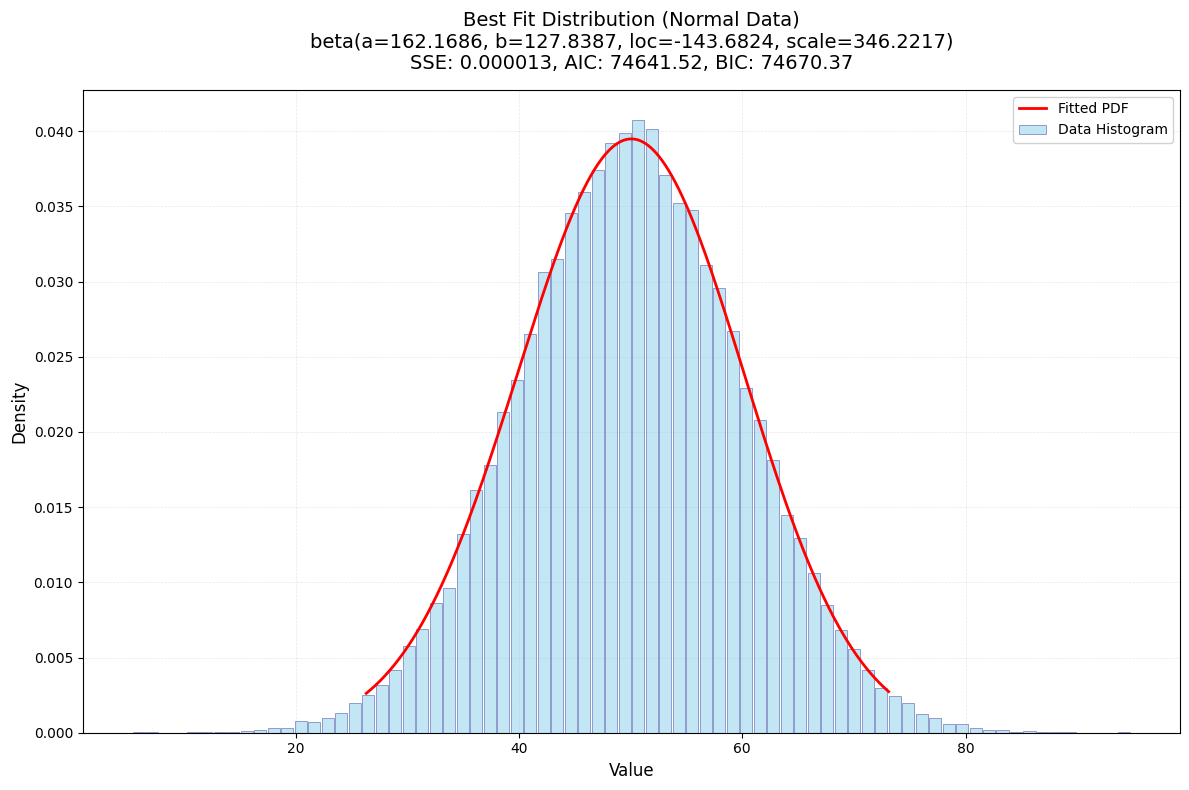

In [22]:
# Basic plot with default config
fig, ax = fitter.plot(
    best,
    df_normal,
    "value",
    title="Best Fit Distribution (Normal Data)",
    xlabel="Value",
    ylabel="Density"
)
plt.show()

## 4.2 Plot with Custom Parameters

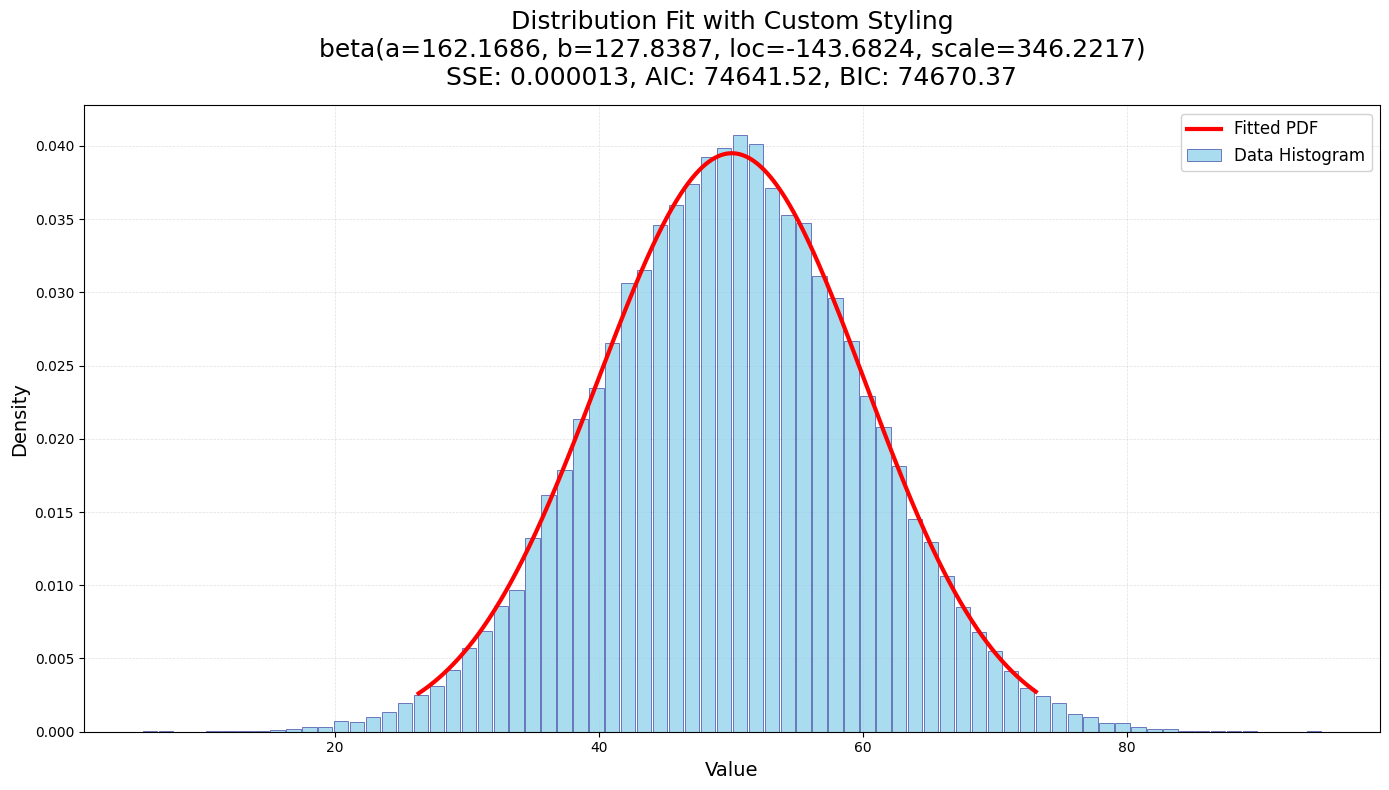

In [23]:
# Custom plot with direct parameters
fig, ax = fitter.plot(
    best,
    df_normal,
    "value",
    figsize=(14, 8),
    dpi=100,
    histogram_alpha=0.7,
    pdf_linewidth=3,
    title_fontsize=18,
    label_fontsize=14,
    legend_fontsize=12,
    grid_alpha=0.4,
    title="Distribution Fit with Custom Styling",
    xlabel="Value",
    ylabel="Density",
)
plt.show()

## 4.3 Plot Non-Negative Distribution

Best fit for exponential data: erlang
  K-S statistic: 0.008116
  p-value: 0.5222


/Users/dustin/Documents/code/spark-bestfit/src/spark_bestfit/fitting.py:952: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(1.00182939).
  start = dist.ppf(percentile, *shape, loc=loc, scale=scale)
/Users/dustin/Documents/code/spark-bestfit/src/spark_bestfit/fitting.py:953: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(1.00182939).
  end = dist.ppf(1 - percentile, *shape, loc=loc, scale=scale)
/Users/dustin/Documents/code/spark-bestfit/src/spark_bestfit/plotting.py:78: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(1.00182939).
  y_pdf = dist.pdf(x_pdf, *shape, loc=loc, scale=scale)


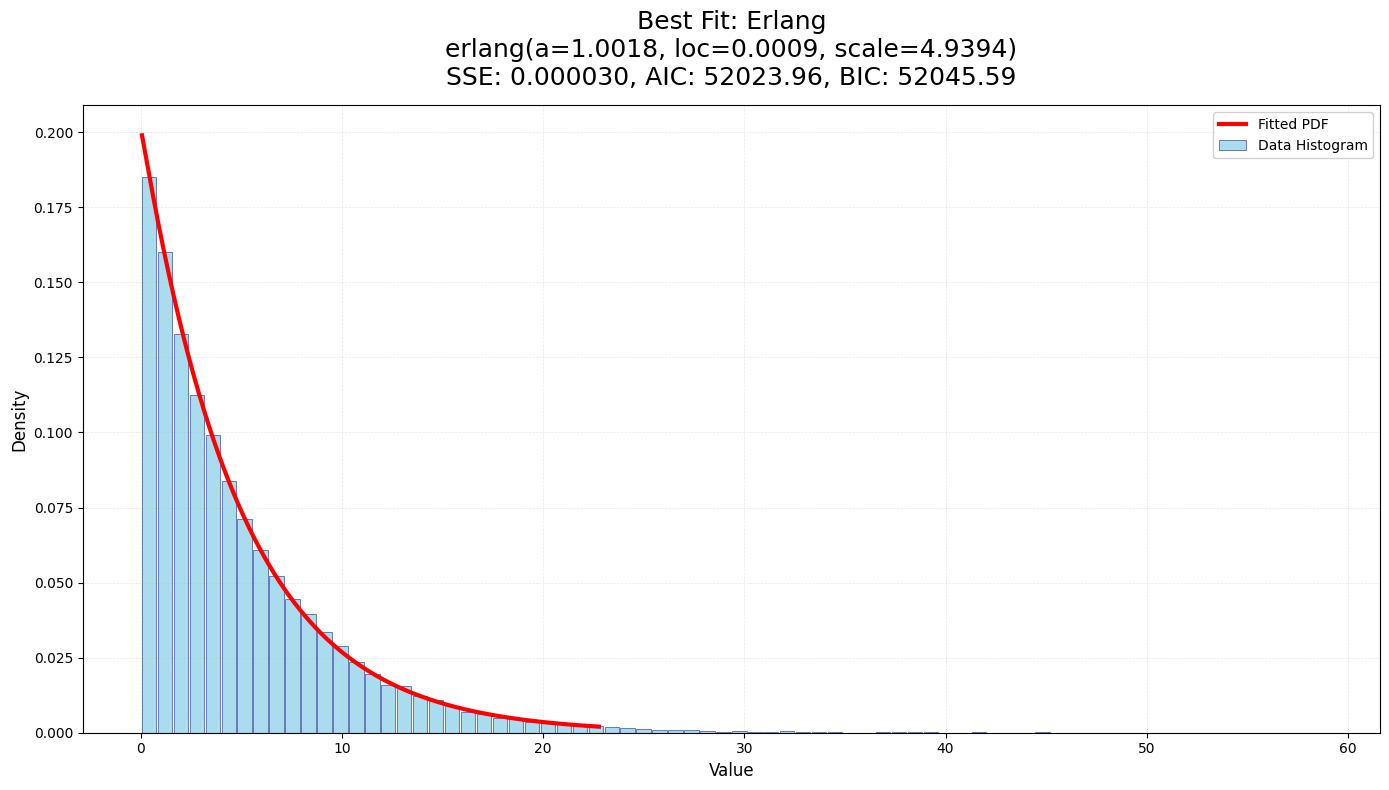

In [24]:
# Best fit for exponential data
best_exp = results_exp.best(n=1)[0]
print(f"Best fit for exponential data: {best_exp.distribution}")
print(f"  K-S statistic: {best_exp.ks_statistic:.6f}")
print(f"  p-value: {best_exp.pvalue:.4f}")

fig, ax = fitter_nonneg.plot(
    best_exp,
    df_exp,
    "value",
    figsize=(14, 8),
    dpi=100,
    histogram_alpha=0.7,
    pdf_linewidth=3,
    title_fontsize=18,
    title=f"Best Fit: {best_exp.distribution.capitalize()}",
    xlabel="Value",
    ylabel="Density",
)
plt.show()

## 4.4 Q-Q Plots for Goodness-of-Fit Assessment

A Q-Q (quantile-quantile) plot is a powerful visual tool for assessing how well a distribution fits your data. It plots sample quantiles against theoretical quantiles from the fitted distribution. If the fit is good, points will fall approximately along the diagonal reference line.

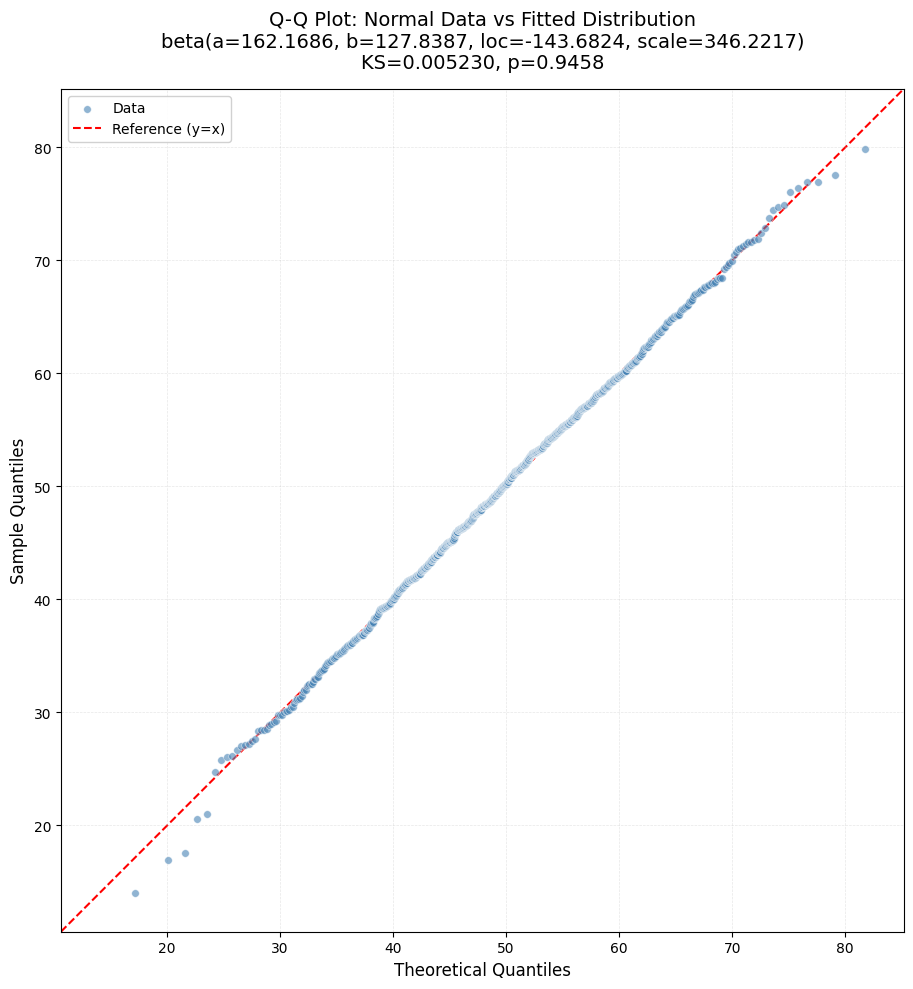

/Users/dustin/.venvs/base/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:533: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(1.00182939).
  return self.dist.ppf(q, *self.args, **self.kwds)


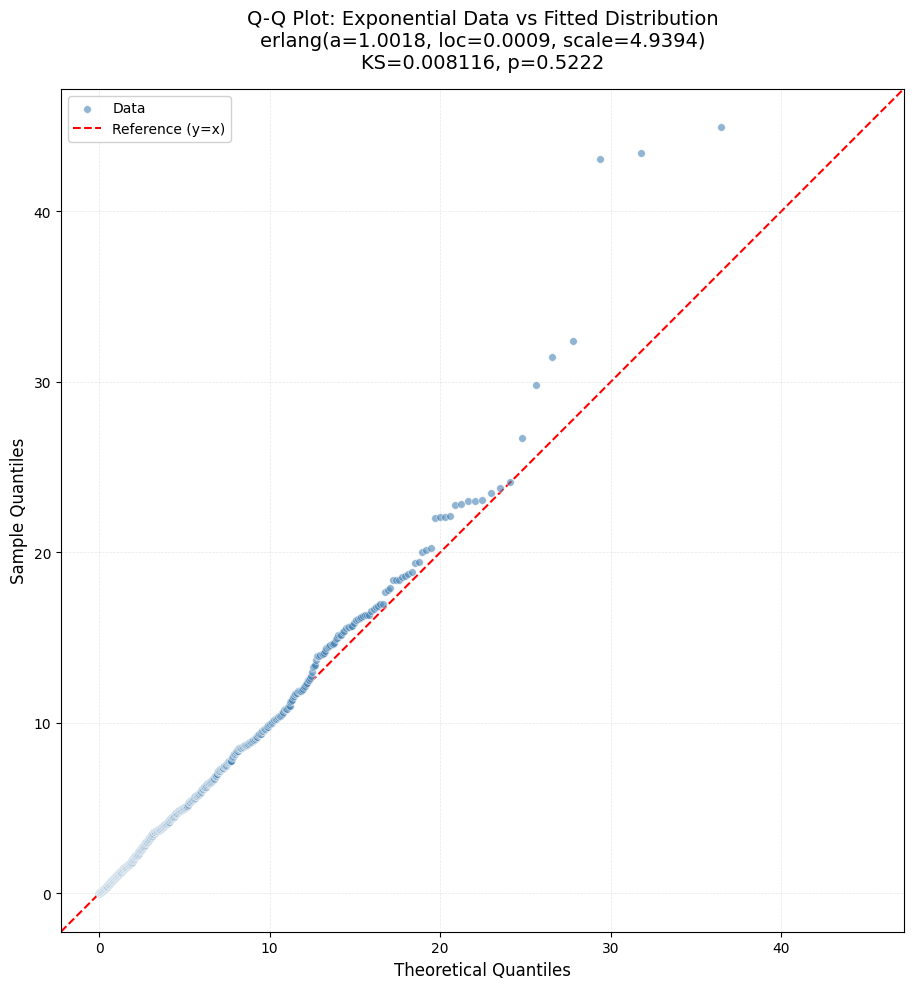

In [25]:
# Q-Q plot for the best fit on normal data
fig, ax = fitter.plot_qq(
    best,
    df_normal,
    "value",
    max_points=1000,  # Sample size for plotting (too many points clutters the plot)
    figsize=(10, 10),
    title="Q-Q Plot: Normal Data vs Fitted Distribution",
)
plt.show()

# Compare: Q-Q plot for exponential data
fig, ax = fitter_nonneg.plot_qq(
    best_exp,
    df_exp,
    "value",
    max_points=1000,
    figsize=(10, 10),
    title="Q-Q Plot: Exponential Data vs Fitted Distribution",
)
plt.show()

## 4.5 P-P Plots for Goodness-of-Fit Assessment

A P-P (probability-probability) plot compares the empirical cumulative distribution function (CDF) of the sample data against the theoretical CDF of the fitted distribution. It is particularly useful for assessing the fit in the center of the distribution.


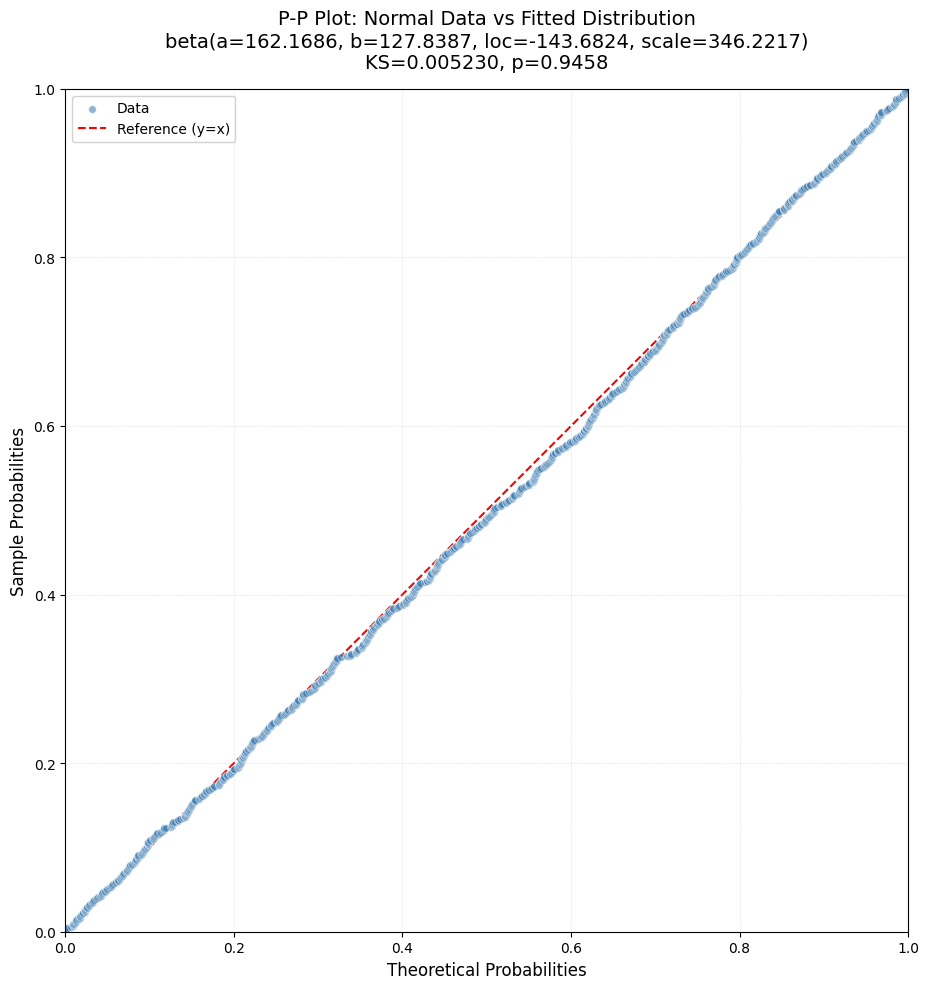

/Users/dustin/.venvs/base/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:527: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(1.00182939).
  return self.dist.cdf(x, *self.args, **self.kwds)


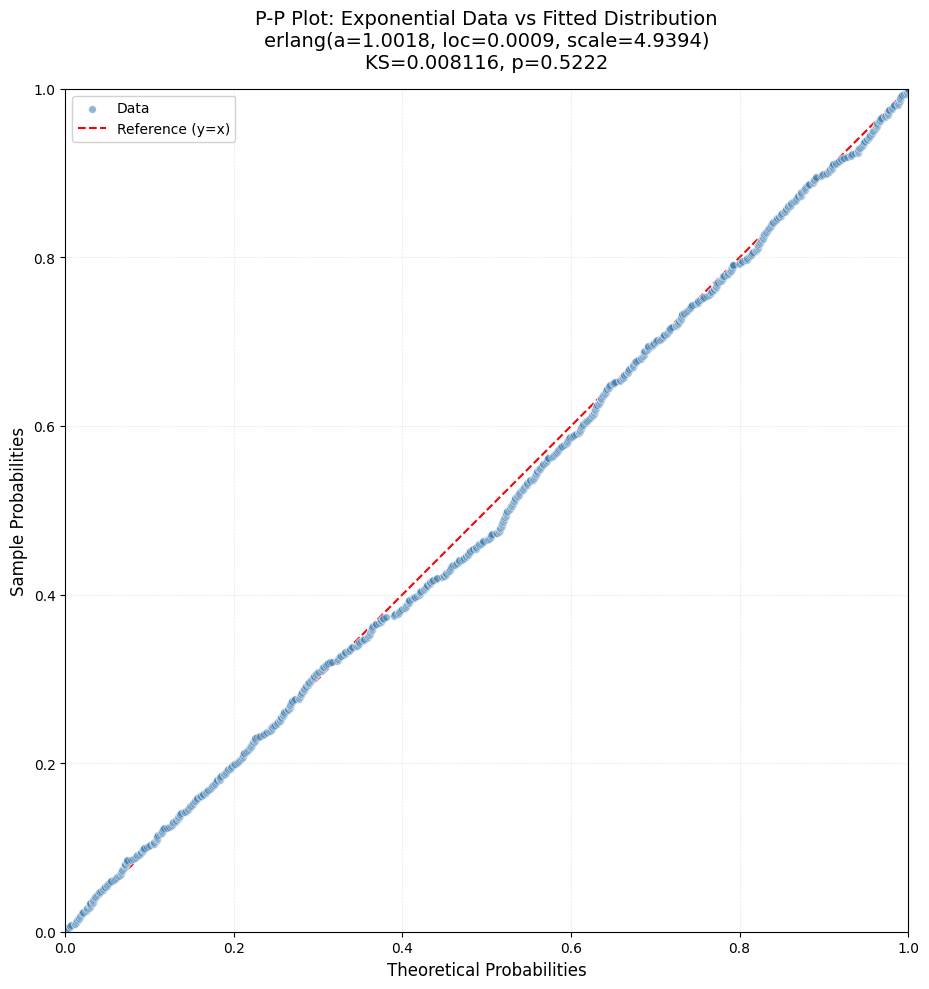

In [26]:
# P-P plot for the best fit on normal data
fig, ax = fitter.plot_pp(
    best,
    df_normal,
    "value",
    max_points=1000,  # Sample size for plotting (too many points clutters the plot)
    figsize=(10, 10),
    title="P-P Plot: Normal Data vs Fitted Distribution",
)
plt.show()

# Compare: P-P plot for exponential data
fig, ax = fitter_nonneg.plot_pp(
    best_exp,
    df_exp,
    "value",
    max_points=1000,
    figsize=(10, 10),
    title="P-P Plot: Exponential Data vs Fitted Distribution",
)
plt.show()

---

# Part 5: Multi-Column Fitting

Fit multiple columns efficiently in a single operation. This shares Spark overhead (count, sampling, broadcasting) across all columns.

## 5.1 Create Multi-Column DataFrame

In [27]:
# Create a DataFrame with multiple columns (different distributions)
np.random.seed(42)

# Generate data from different distributions
n_rows = 20_000
multi_data = [
    (
        float(np.random.normal(50, 10)),      # normal_col
        float(np.random.exponential(5)),      # exp_col
        float(np.random.gamma(2.0, 2.0)),     # gamma_col
    )
    for _ in range(n_rows)
]

df_multi = spark.createDataFrame(multi_data, ["normal_col", "exp_col", "gamma_col"])
print(f"Created DataFrame with {df_multi.count():,} rows and columns: {df_multi.columns}")

Created DataFrame with 20,000 rows and columns: ['normal_col', 'exp_col', 'gamma_col']


## 5.2 Fit Multiple Columns in One Call

In [28]:
# Fit distributions to all columns in a single operation
# This is more efficient than fitting each column separately
print("Fitting distributions to 3 columns simultaneously...")

fitter_multi = DistributionFitter(spark)
results_multi = fitter_multi.fit(
    df_multi,
    columns=["normal_col", "exp_col", "gamma_col"],  # Multi-column fitting!
    max_distributions=15,
)

print(f"\nTotal results: {results_multi.count()}")
print(f"Columns fitted: {results_multi.column_names}")

Fitting distributions to 3 columns simultaneously...



Total results: 45
Columns fitted: ['normal_col', 'exp_col', 'gamma_col']


## 5.3 Get Best Distribution Per Column

In [29]:
# Get the best distribution for each column
best_per_col = results_multi.best_per_column(n=1)

print("Best distribution per column:")
for col_name, fits in best_per_col.items():
    best = fits[0]
    print(f"\n{col_name}:")
    print(f"  Distribution: {best.distribution}")
    print(f"  K-S statistic: {best.ks_statistic:.6f}")
    print(f"  p-value: {best.pvalue:.4f}")
    print(f"  Parameters: {[f'{p:.4f}' for p in best.parameters]}")

Best distribution per column:

normal_col:
  Distribution: beta
  K-S statistic: 0.005203
  p-value: 0.9471
  Parameters: ['5567.0605', '569151.6250', '-705.2714', '77970.4062']

exp_col:
  Distribution: beta
  K-S statistic: 0.006369
  p-value: 0.8069
  Parameters: ['1.0146', '79.1006', '0.0005', '392.2227']

gamma_col:
  Distribution: betaprime
  K-S statistic: 0.004982
  p-value: 0.9632
  Parameters: ['2.0366', '9788.9043', '-0.0090', '19305.3398']


## 5.4 Filter Results by Column

In [30]:
# Get results for a specific column
exp_results = results_multi.for_column("exp_col")

print(f"Results for 'exp_col': {exp_results.count()} distributions")
print("\nTop 5 by K-S statistic:")
for i, r in enumerate(exp_results.best(n=5), 1):
    print(f"  {i}. {r.distribution:15} KS={r.ks_statistic:.6f}")

Results for 'exp_col': 15 distributions

Top 5 by K-S statistic:
  1. beta            KS=0.006369
  2. chi2            KS=0.006375
  3. burr12          KS=0.006666
  4. betaprime       KS=0.007770
  5. burr            KS=0.017501


## 5.5 Plot Results for Each Column

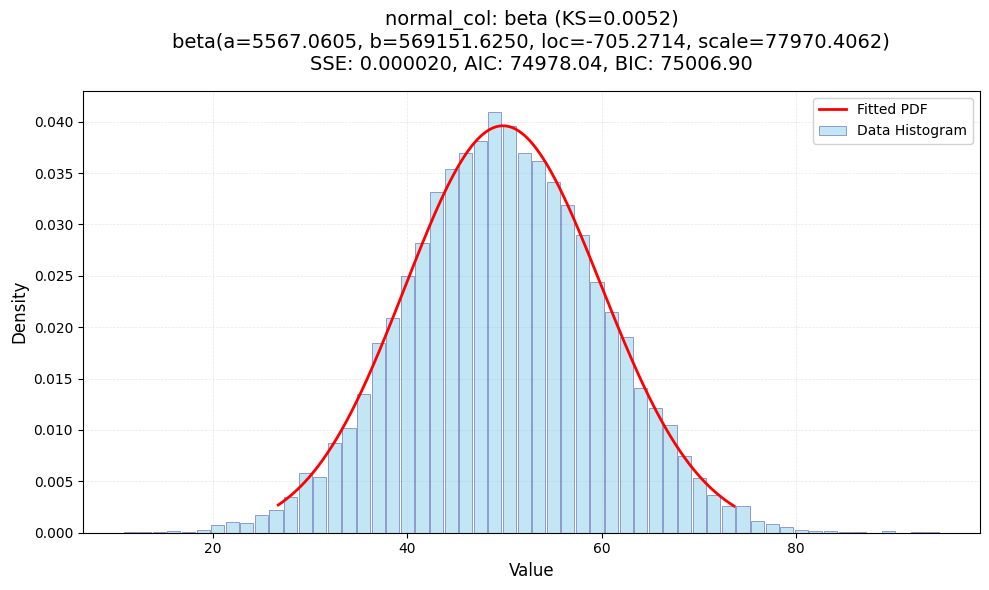

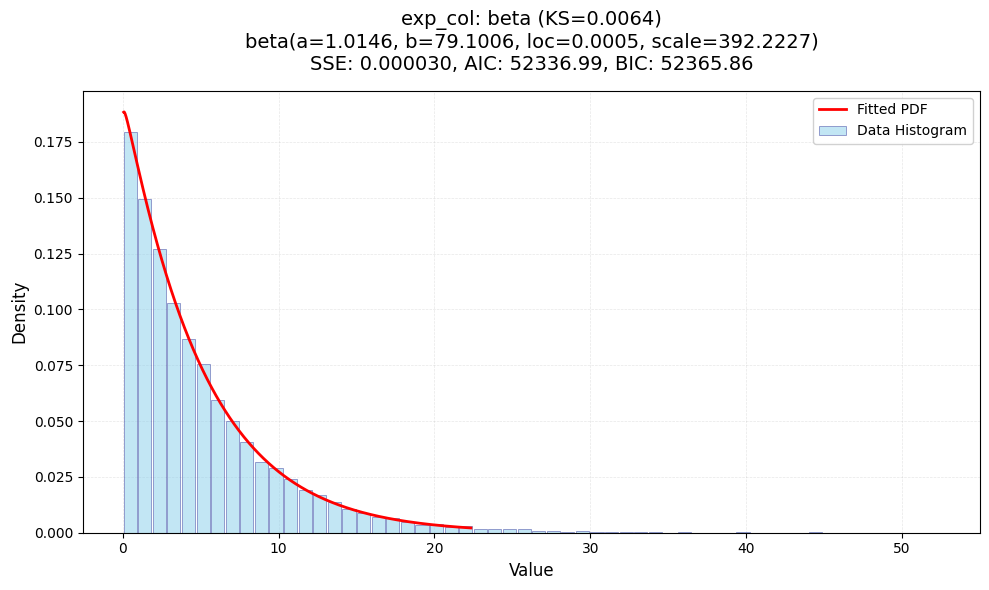

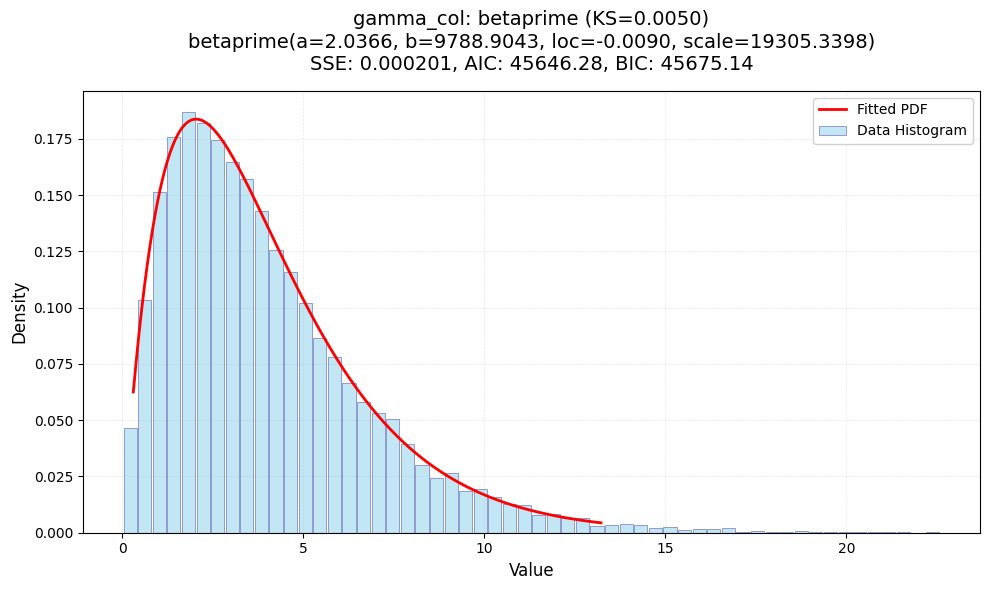

In [31]:
# Plot the best fit for each column
for col_name, fits in best_per_col.items():
    best = fits[0]
    fig, ax = fitter_multi.plot(
        best,
        df_multi,
        col_name,
        title=f"{col_name}: {best.distribution} (KS={best.ks_statistic:.4f})",
        xlabel="Value",
        ylabel="Density",
        figsize=(10, 6),
    )
    plt.show()

---

# Part 6: Complete Workflow Example

Putting it all together - a complete production-style workflow.

Fitting gamma distribution data...



Best distribution: beta
K-S statistic: 0.005444
p-value: 0.9265
SSE: 0.000308
Parameters: ['1.9708', '57.3430', '-0.0117', '120.5071']


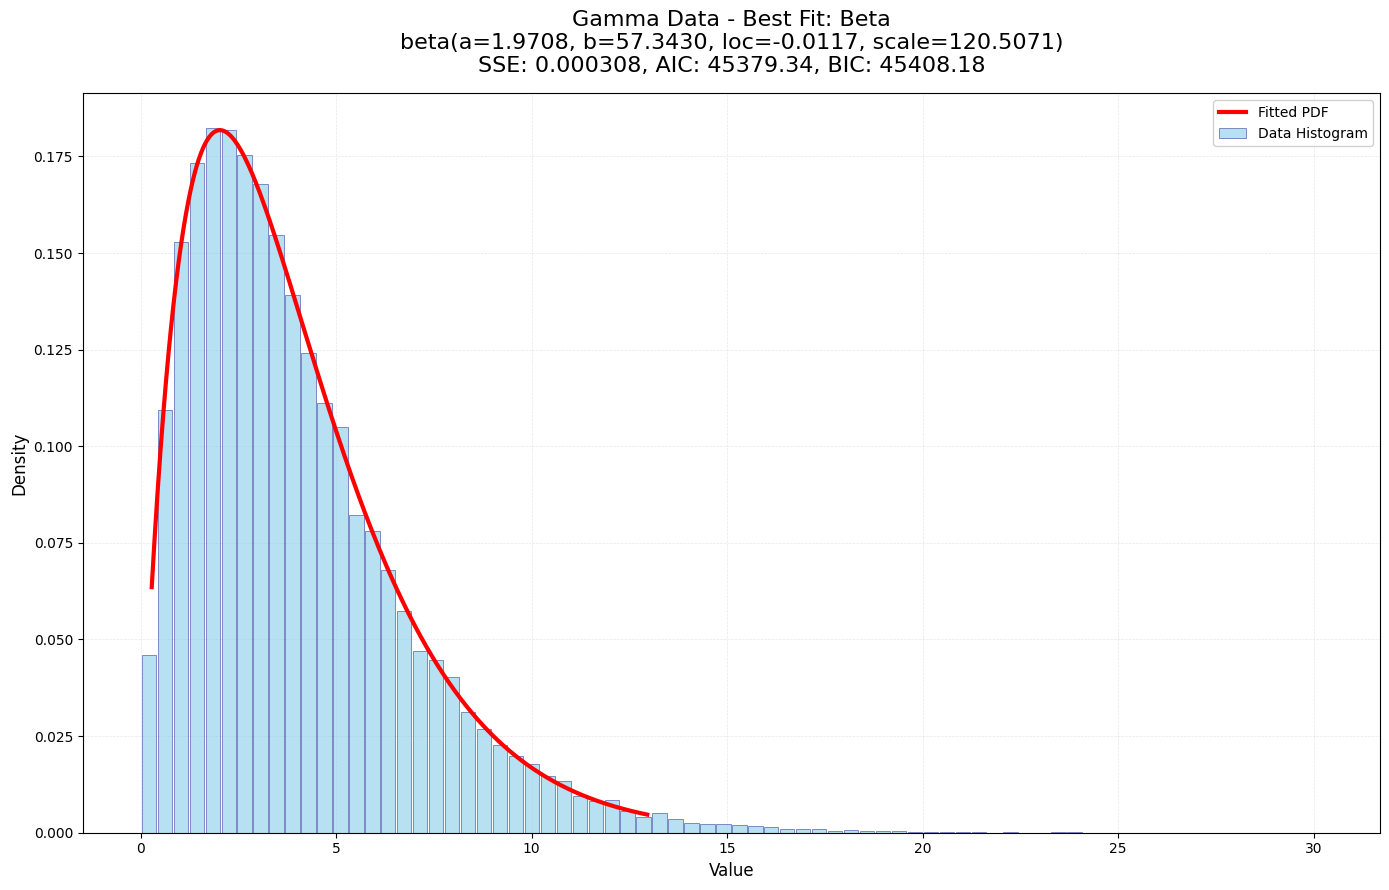


Top 5 distributions:


,distribution,ks_statistic,pvalue,sse,aic,bic
8,beta,0.005444,0.926528,0.000308,45379.339844,45408.183594
18,erlang,0.005588,0.911703,0.000252,45380.265625,45401.898438
20,chi2,0.005590,0.911536,0.000252,45380.265625,45401.898438
10,f,0.005597,0.910702,0.000251,45382.265625,45411.109375
24,exponweib,0.006066,0.852823,0.000312,45381.195312,45410.039062


In [32]:
# Complete workflow with all parameters
fitter_gamma = DistributionFitter(spark, random_seed=42)

# Fit distributions
print("Fitting gamma distribution data...")
results = fitter_gamma.fit(
    df_gamma,
    column="value",
    bins=100,
    use_rice_rule=False,
    enable_sampling=True,
    max_sample_size=1_000_000,
    max_distributions=25,
)

# Get best result
best = results.best(n=1)[0]
print(f"\nBest distribution: {best.distribution}")
print(f"K-S statistic: {best.ks_statistic:.6f}")
print(f"p-value: {best.pvalue:.4f}")
print(f"SSE: {best.sse:.6f}")
print(f"Parameters: {[f'{p:.4f}' for p in best.parameters]}")

# Plot with custom parameters
fig, ax = fitter_gamma.plot(
    best,
    df_gamma,
    "value",
    figsize=(14, 9),
    dpi=150,
    histogram_alpha=0.6,
    pdf_linewidth=3,
    title_fontsize=16,
    title=f"Gamma Data - Best Fit: {best.distribution.capitalize()}",
    xlabel="Value",
    ylabel="Density",
)
plt.show()

# Show top 5 results (sorted by K-S statistic for meaningful ranking)
print("\nTop 5 distributions:")
df_top5 = results.df.toPandas().sort_values("ks_statistic").head(5)
df_top5[["distribution", "ks_statistic", "pvalue", "sse", "aic", "bic"]]

---

# Part 7: Serialization

Save fitted distributions to disk and reload them later for inference without re-fitting.

## 7.1 Save and Load

Save a fitted distribution to JSON (default) or pickle format.

In [33]:
import tempfile
import os
from pathlib import Path

# Use the best fit from Part 6
print(f"Saving distribution: {best.distribution}")
print(f"Parameters: {best.parameters}")

# Save to a temporary directory
model_dir = Path(tempfile.mkdtemp())
json_path = model_dir / "best_model.json"
pkl_path = model_dir / "best_model.pkl"

# Save as JSON (human-readable, default)
best.save(json_path)
print(f"\nSaved to JSON: {json_path}")
print(f"File size: {json_path.stat().st_size:,} bytes")

# Save as pickle (binary, faster)
best.save(pkl_path, format="pickle")
print(f"\nSaved to pickle: {pkl_path}")
print(f"File size: {pkl_path.stat().st_size:,} bytes")

Saving distribution: beta
Parameters: [1.9708176851272583, 57.34297180175781, -0.01165021862834692, 120.50712585449219]

Saved to JSON: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmpua1h_w3o/best_model.json
File size: 756 bytes

Saved to pickle: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmpua1h_w3o/best_model.pkl
File size: 424 bytes


In [34]:
from spark_bestfit import DistributionFitResult

# Load the saved model
loaded = DistributionFitResult.load(json_path)

print(f"Loaded distribution: {loaded.distribution}")
print(f"Parameters: {loaded.parameters}")
print(f"K-S statistic: {loaded.ks_statistic:.6f}")
print(f"p-value: {loaded.pvalue:.4f}")

# Verify loaded model works
samples = loaded.sample(size=1000, random_state=42)
print(f"\nGenerated {len(samples)} samples from loaded model")
print(f"Sample mean: {samples.mean():.2f}")
print(f"Sample std: {samples.std():.2f}")

Loaded distribution: beta
Parameters: [1.9708176851272583, 57.34297180175781, -0.01165021862834692, 120.50712585449219]
K-S statistic: 0.005444
p-value: 0.9265

Generated 1000 samples from loaded model
Sample mean: 4.09
Sample std: 2.73


## 7.2 Data Summary

When fitting with `DistributionFitter`, the result includes a `data_summary` field
with statistics about the fitted data. This provides lightweight provenance tracking.

In [35]:
# Access data summary from the loaded model
if loaded.data_summary:
    summary = loaded.data_summary
    print("Data Summary (from fitting):")
    print(f"  Sample size: {summary['sample_size']:,.0f}")
    print(f"  Min: {summary['min']:.4f}")
    print(f"  Max: {summary['max']:.4f}")
    print(f"  Mean: {summary['mean']:.4f}")
    print(f"  Std: {summary['std']:.4f}")
else:
    print("No data summary available (result may have been created manually)")

Data Summary (from fitting):
  Sample size: 10,007
  Min: 0.0093
  Max: 22.3278
  Mean: 3.9924
  Std: 2.7826


## 7.3 JSON Format

The JSON format is human-readable and includes version metadata for compatibility.

In [36]:
# View the JSON content
with open(json_path) as f:
    content = f.read()

print("JSON file content:")
print(content)

JSON file content:
{
  "schema_version": "1.1",
  "spark_bestfit_version": "1.5.0",
  "created_at": "2026-01-01T14:37:04.990125+00:00",
  "distribution": "beta",
  "parameters": [
    1.9708176851272583,
    57.34297180175781,
    -0.01165021862834692,
    120.50712585449219
  ],
  "column_name": "value",
  "metrics": {
    "sse": 0.0003081703616771847,
    "aic": 45379.33984375,
    "bic": 45408.18359375,
    "ks_statistic": 0.005444108508527279,
    "pvalue": 0.9265276193618774,
    "ad_statistic": 0.3376624286174774,
    "ad_pvalue": null
  },
  "data_summary": {
    "std": 2.782562732696533,
    "min": 0.009250038303434849,
    "sample_size": 10007.0,
    "max": 22.32782554626465,
    "mean": 3.992417812347412
  },
  "lower_bound": null,
  "upper_bound": null
}


In [37]:
# Cleanup temporary files
import shutil
shutil.rmtree(model_dir)
print(f"Cleaned up temporary directory: {model_dir}")

Cleaned up temporary directory: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmpua1h_w3o


---

## Summary

This notebook demonstrated:

1. **Excluded Distributions**:
   - `DEFAULT_EXCLUDED_DISTRIBUTIONS` - Slow distributions excluded by default
   - Pass custom `excluded_distributions` to `DistributionFitter()` to include/exclude

2. **SparkSession Management**:
   - You create and configure your own SparkSession
   - Pass it to `DistributionFitter(spark)` or use active session

3. **Fitting**:
   - `DistributionFitter.fit()` - Fit distributions to data
   - Parameters: `bins`, `use_rice_rule`, `support_at_zero`, `enable_sampling`, etc.
   - `max_distributions` parameter to limit fitting scope
   - `progress_callback` parameter to monitor long-running fits

4. **Progress Tracking**:
   - Pass `progress_callback=fn` to `fit()` to receive progress updates
   - Callback receives `(completed_tasks, total_tasks, percent_complete)`
   - Works with both `DistributionFitter` and `DiscreteDistributionFitter`

5. **Results**:
   - `results.best(n, metric)` - Get top N by K-S statistic (default), A-D statistic, SSE, AIC, or BIC
   - `results.filter(ks_threshold, pvalue_threshold, ad_threshold)` - Filter by goodness-of-fit
   - `results.df.toPandas()` - Convert to pandas DataFrame
   - `DistributionFitResult.sample()`, `.pdf()`, `.cdf()` - Use fitted distribution
   - `DistributionFitResult.get_param_names()` - Get parameter names
   - `DistributionFitResult.confidence_intervals()` - Bootstrap confidence intervals

6. **Lazy Metrics (v1.5.0+)**:
   - `lazy_metrics=True` - Skip KS/AD computation during fitting for faster iteration
   - `results.is_lazy` - Check if results have lazy metrics
   - `results.best(metric="ks_statistic")` - Triggers on-demand computation for top candidates only
   - `results.materialize()` - Force computation of all KS/AD statistics

7. **Multi-Column Fitting**:
   - `fitter.fit(df, columns=[...])` - Fit multiple columns in one call
   - `results.column_names` - List all fitted columns
   - `results.for_column(name)` - Filter results to one column
   - `results.best_per_column(n, metric)` - Get top N per column

8. **Plotting**:
   - `fitter.plot()` - Visualize fitted distribution with data histogram
   - `fitter.plot_qq()` - Q-Q plot for visual goodness-of-fit assessment
   - `fitter.plot_pp()` - P-P plot for assessing fit in the center of distribution
   - Customizable with `figsize`, `dpi`, `histogram_alpha`, `pdf_linewidth`, etc.

9. **Serialization**:
   - `result.save(path)` - Save to JSON (default) or pickle format
   - `DistributionFitResult.load(path)` - Load a saved result
   - `result.data_summary` - Access fitting statistics for provenance
   - JSON format includes version metadata for compatibility

10. **Goodness-of-Fit Metrics**:
    - **K-S statistic** (default) - Lower is better, measures max distance from empirical CDF
    - **A-D statistic** - Lower is better, more sensitive to tails than K-S
    - **p-value** - Higher is better (>0.05 suggests good fit)
    - **A-D p-value** - Only available for norm, expon, logistic, gumbel_r, gumbel_l
    - **SSE** - Sum of squared errors between histogram and fitted PDF
    - **AIC/BIC** - Information criteria for model comparison

In [38]:
spark.stop()
print("Spark session stopped.")

Spark session stopped.
